In [1]:
#importing the libraries we need
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn
import re
from torch.autograd import Variable

from utils import *
from  models.VGG16Model import CNNModel
from models.trainCNN import trainCNN

torch.cuda.empty_cache()

In [2]:
#assigning the type of device that we will work on
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#device =  torch.device('cpu')

In [3]:
#loading the names of the frames and thier classes
train_frames = pd.read_csv('frames_train_1.csv') 
test_frames = pd.read_csv('frames_test_1.csv') 

train_videos = pd.read_csv('video_train_1.csv') 
test_videos = pd.read_csv('video_test_1_classes.csv')

In [4]:
train_frames.head()

,name,class
0,v_ApplyEyeMakeup_g08_c01.avi_1.jpg,1
1,v_ApplyEyeMakeup_g08_c01.avi_2.jpg,1
2,v_ApplyEyeMakeup_g08_c01.avi_3.jpg,1
3,v_ApplyEyeMakeup_g08_c01.avi_4.jpg,1
4,v_ApplyEyeMakeup_g08_c01.avi_5.jpg,1


In [5]:
test_frames.head()

,name,class
0,v_ApplyEyeMakeup_g01_c01.avi_1.jpg,1
1,v_ApplyEyeMakeup_g01_c01.avi_2.jpg,1
2,v_ApplyEyeMakeup_g01_c01.avi_3.jpg,1
3,v_ApplyEyeMakeup_g01_c01.avi_4.jpg,1
4,v_ApplyEyeMakeup_g01_c01.avi_5.jpg,1


In [6]:
train_videos.head()

,name,class,num_frames
0,v_ApplyEyeMakeup_g08_c01.avi,1,24
1,v_ApplyEyeMakeup_g08_c02.avi,1,23
2,v_ApplyEyeMakeup_g08_c03.avi,1,29
3,v_ApplyEyeMakeup_g08_c04.avi,1,44
4,v_ApplyEyeMakeup_g08_c05.avi,1,55


In [7]:
test_videos.head()

,name,num_frames,class
0,v_ApplyEyeMakeup_g01_c01.avi,32,1
1,v_ApplyEyeMakeup_g01_c02.avi,24,1
2,v_ApplyEyeMakeup_g01_c03.avi,51,1
3,v_ApplyEyeMakeup_g01_c04.avi,47,1
4,v_ApplyEyeMakeup_g01_c05.avi,59,1


## *let's work on the CNN model*

In [8]:
class Resize(object):
    """Resize the image to a given size.

    Args:
        output_size (tuple): Desired output size of the image. should be like (new_h , new_w)
    """

    def __init__(self, output_size):
        
        assert len(output_size) == 2 , "the output size must be of lenght 2 >>> (new_h , new_w)"
        self.output_size = output_size

    def __call__(self, image):
        
        new_h , new_w = self.output_size

        image = cv2.resize(src = image, dsize = (new_w,new_h))


        return image
    
    
class Scale(object):
    """Rescale the image pixel values to be between zero and one.

    Args:
        output_size (tuple): Desired output size of the image. should be like (new_h , new_w)
    """

    def __call__(self, image):


        return image / 255


class ToTensor(object):
    """Reshaping the ndarrays then Converting them to Tensors to be ready to fed to a FFNN."""

    def __call__(self, image):

        
        #Reshaping numpy image: H x W x C to torch Tensor : C x H x W
        image = image.transpose((2,0,1))
        
        return torch.from_numpy(image)

In [9]:
#validation/train ratio
validation_ratio = 0.1

Image_output_size = (224,224) #output size of the images

train_batch_size = 32
val_batch_size = 8

#splitting the train_videos into train and validation frames
#the output from the function below is a data frame that holds the names of the *frames* and thier labels for train and validation
tr_frames , val_frames = trainValSpliteFromVideoNames(validation_ratio , train_videos) 

#the transform steps that we will execute on the images
transform  =torchvision.transforms.Compose([
    Resize(Image_output_size), #resizing the images
    ToTensor(), #transforming the images to Tensor form on the available device (GPU or CPU)
    Scale()   #scaling the images pixel values to be in range zero to one
    
])

#tr_frames.sample(n=train_batch_size).reset_index()

#intializing the image generator
train_gen = UCF101DatasetFrames(frame_name =tr_frames.sample(n=train_batch_size).reset_index(), img_dir ='Train_Frames_1/', shuffle = True , transform = transform)

#intializing the validation image generator
val_gen = UCF101DatasetFrames(frame_name =val_frames, img_dir ='Train_Frames_1/', shuffle = True , transform = transform)

#intializing the train batches loader !!!
train_loader = DataLoader(train_gen , batch_size= train_batch_size , shuffle = True)

#intializing the val batches loader !!!
val_loader = DataLoader(val_gen , batch_size= val_batch_size , shuffle = True)

In [10]:
output_features = 101 #the number of labels
lr = 0.0001 #learning rate



model = CNNModel(output_features).to(device)   #intializing the model
lossFunc = nn.NLLLoss().to(device) #the loss funstion to train on (Negative Likelihood loss since it's a classification task and the logits are log softmax)
optimizer = torch.optim.Adam(model.parameters(), lr = lr ) #the optimization algorithm we use during training

epochs = 2 #num of epoches

In [11]:
tr_loss_lis, tr_acc_lis, val_loss_lis, val_acc_lis = trainCNN (model , lossFunc, optimizer , epochs , train_loader , val_loader , device)

[1, 0] train_loss: 4.61975 train_acc: 0.00000 val_loss: 4.61853 val_acc: 0.00000
[1, 10] train_loss: 4.46195 train_acc: 3.43750 val_loss: 4.59624 val_acc: 5.00000
[1, 20] train_loss: 4.26764 train_acc: 9.06250 val_loss: 4.51077 val_acc: 0.00000
[1, 30] train_loss: 4.16729 train_acc: 10.31250 val_loss: 4.27486 val_acc: 6.25000
[1, 40] train_loss: 4.19870 train_acc: 10.62500 val_loss: 4.01095 val_acc: 11.25000
[1, 50] train_loss: 4.00547 train_acc: 15.31250 val_loss: 3.87452 val_acc: 17.50000
[1, 60] train_loss: 3.76036 train_acc: 16.87500 val_loss: 3.76541 val_acc: 17.50000
[1, 70] train_loss: 3.87263 train_acc: 15.31250 val_loss: 4.05990 val_acc: 13.75000
[1, 80] train_loss: 3.67828 train_acc: 19.37500 val_loss: 3.68433 val_acc: 10.00000
[1, 90] train_loss: 3.61056 train_acc: 19.06250 val_loss: 3.82396 val_acc: 13.75000
[1, 100] train_loss: 3.65373 train_acc: 19.68750 val_loss: 3.39128 val_acc: 16.25000
[1, 110] train_loss: 3.68597 train_acc: 17.81250 val_loss: 3.59077 val_acc: 17.5000

[1, 960] train_loss: 1.03510 train_acc: 74.68750 val_loss: 1.27989 val_acc: 68.75000
[1, 970] train_loss: 1.16717 train_acc: 71.56250 val_loss: 1.07568 val_acc: 71.25000
[1, 980] train_loss: 1.23302 train_acc: 68.43750 val_loss: 1.62163 val_acc: 62.50000
[1, 990] train_loss: 1.09180 train_acc: 75.31250 val_loss: 1.30690 val_acc: 67.50000
[1, 1000] train_loss: 0.92719 train_acc: 77.18750 val_loss: 1.07268 val_acc: 71.25000
[1, 1010] train_loss: 1.09874 train_acc: 74.06250 val_loss: 1.06413 val_acc: 73.75000
[1, 1020] train_loss: 0.98521 train_acc: 74.37500 val_loss: 0.88925 val_acc: 75.00000
[1, 1030] train_loss: 1.09500 train_acc: 71.25000 val_loss: 1.27246 val_acc: 63.75000
[1, 1040] train_loss: 1.07921 train_acc: 73.12500 val_loss: 1.55815 val_acc: 63.75000
[1, 1050] train_loss: 1.20562 train_acc: 69.68750 val_loss: 1.09064 val_acc: 75.00000
[1, 1060] train_loss: 1.21588 train_acc: 68.43750 val_loss: 1.11375 val_acc: 76.25000
[1, 1070] train_loss: 1.01964 train_acc: 76.56250 val_loss

[1, 1910] train_loss: 0.66915 train_acc: 83.12500 val_loss: 1.03178 val_acc: 78.75000
[1, 1920] train_loss: 0.49276 train_acc: 85.93750 val_loss: 0.85943 val_acc: 78.75000
[1, 1930] train_loss: 0.42823 train_acc: 89.68750 val_loss: 1.03843 val_acc: 77.50000
[1, 1940] train_loss: 0.52246 train_acc: 85.31250 val_loss: 0.90317 val_acc: 77.50000
[1, 1950] train_loss: 0.56214 train_acc: 87.18750 val_loss: 0.96489 val_acc: 76.25000
[1, 1960] train_loss: 0.69935 train_acc: 81.56250 val_loss: 0.86402 val_acc: 77.50000
[1, 1970] train_loss: 0.50422 train_acc: 87.81250 val_loss: 0.92163 val_acc: 76.25000
[1, 1980] train_loss: 0.64416 train_acc: 83.75000 val_loss: 0.60458 val_acc: 81.25000
[1, 1990] train_loss: 0.58195 train_acc: 85.31250 val_loss: 0.61025 val_acc: 83.75000
[1, 2000] train_loss: 0.60712 train_acc: 83.75000 val_loss: 0.86620 val_acc: 81.25000
[1, 2010] train_loss: 0.52470 train_acc: 87.50000 val_loss: 1.21596 val_acc: 72.50000
[1, 2020] train_loss: 0.50559 train_acc: 85.93750 val_

[1, 2860] train_loss: 0.27149 train_acc: 93.12500 val_loss: 0.62014 val_acc: 85.00000
[1, 2870] train_loss: 0.34726 train_acc: 92.18750 val_loss: 0.98368 val_acc: 75.00000
[1, 2880] train_loss: 0.55189 train_acc: 85.93750 val_loss: 0.76218 val_acc: 85.00000
[1, 2890] train_loss: 0.44146 train_acc: 89.37500 val_loss: 0.84242 val_acc: 80.00000
[1, 2900] train_loss: 0.47075 train_acc: 87.18750 val_loss: 0.94704 val_acc: 75.00000
[1, 2910] train_loss: 0.49661 train_acc: 86.87500 val_loss: 0.72549 val_acc: 83.75000
[1, 2920] train_loss: 0.38277 train_acc: 90.00000 val_loss: 1.05237 val_acc: 77.50000
[1, 2930] train_loss: 0.37256 train_acc: 90.00000 val_loss: 0.53982 val_acc: 85.00000
[1, 2940] train_loss: 0.30784 train_acc: 91.87500 val_loss: 0.59046 val_acc: 86.25000
[1, 2950] train_loss: 0.36073 train_acc: 89.06250 val_loss: 0.41031 val_acc: 91.25000
[1, 2960] train_loss: 0.31015 train_acc: 91.25000 val_loss: 0.78765 val_acc: 80.00000
[1, 2970] train_loss: 0.33146 train_acc: 89.06250 val_

[1, 3810] train_loss: 0.33605 train_acc: 90.62500 val_loss: 0.33161 val_acc: 87.50000
[1, 3820] train_loss: 0.23283 train_acc: 95.00000 val_loss: 0.30723 val_acc: 92.50000
[1, 3830] train_loss: 0.27322 train_acc: 94.06250 val_loss: 0.81467 val_acc: 82.50000
[1, 3840] train_loss: 0.30187 train_acc: 91.25000 val_loss: 0.55793 val_acc: 83.75000
[1, 3850] train_loss: 0.26246 train_acc: 92.18750 val_loss: 0.40149 val_acc: 87.50000
[1, 3860] train_loss: 0.17746 train_acc: 95.62500 val_loss: 0.58915 val_acc: 87.50000
[1, 3870] train_loss: 0.36316 train_acc: 89.37500 val_loss: 0.54474 val_acc: 86.25000
[1, 3880] train_loss: 0.22939 train_acc: 91.56250 val_loss: 0.96574 val_acc: 80.00000
[1, 3890] train_loss: 0.33491 train_acc: 92.18750 val_loss: 0.33943 val_acc: 92.50000
[1, 3900] train_loss: 0.36293 train_acc: 89.37500 val_loss: 0.78117 val_acc: 85.00000
[1, 3910] train_loss: 0.22439 train_acc: 93.75000 val_loss: 0.51880 val_acc: 88.75000
[1, 3920] train_loss: 0.30043 train_acc: 91.87500 val_

[1, 4760] train_loss: 0.19207 train_acc: 94.06250 val_loss: 0.45476 val_acc: 86.25000
[1, 4770] train_loss: 0.19983 train_acc: 94.06250 val_loss: 0.49958 val_acc: 87.50000
[1, 4780] train_loss: 0.22542 train_acc: 93.12500 val_loss: 0.34619 val_acc: 90.00000
[1, 4790] train_loss: 0.19190 train_acc: 95.00000 val_loss: 0.63103 val_acc: 87.50000
[1, 4800] train_loss: 0.24342 train_acc: 94.37500 val_loss: 0.69784 val_acc: 81.25000
[1, 4810] train_loss: 0.29656 train_acc: 93.12500 val_loss: 0.54071 val_acc: 86.25000
[1, 4820] train_loss: 0.25357 train_acc: 93.43750 val_loss: 0.68980 val_acc: 83.75000
[1, 4830] train_loss: 0.25014 train_acc: 93.75000 val_loss: 0.36258 val_acc: 91.25000
[1, 4840] train_loss: 0.16078 train_acc: 94.68750 val_loss: 0.56112 val_acc: 85.00000
[1, 4850] train_loss: 0.27115 train_acc: 94.68750 val_loss: 0.63589 val_acc: 88.75000
[1, 4860] train_loss: 0.14607 train_acc: 96.25000 val_loss: 0.91928 val_acc: 83.75000
[1, 4870] train_loss: 0.25520 train_acc: 92.18750 val_

[1, 5710] train_loss: 0.15362 train_acc: 94.68750 val_loss: 0.53752 val_acc: 88.75000
[1, 5720] train_loss: 0.10817 train_acc: 96.25000 val_loss: 0.75661 val_acc: 85.00000
[1, 5730] train_loss: 0.19824 train_acc: 94.68750 val_loss: 0.57773 val_acc: 87.50000
[1, 5740] train_loss: 0.25168 train_acc: 94.37500 val_loss: 0.36683 val_acc: 93.75000
[1, 5750] train_loss: 0.23767 train_acc: 92.81250 val_loss: 0.06553 val_acc: 98.75000
[1, 5760] train_loss: 0.15287 train_acc: 95.31250 val_loss: 0.28160 val_acc: 91.25000
[1, 5770] train_loss: 0.14819 train_acc: 95.00000 val_loss: 0.67839 val_acc: 87.50000
[1, 5780] train_loss: 0.17647 train_acc: 94.06250 val_loss: 0.87088 val_acc: 83.75000
[1, 5790] train_loss: 0.17584 train_acc: 95.93750 val_loss: 0.72760 val_acc: 86.25000
[1, 5800] train_loss: 0.22250 train_acc: 92.81250 val_loss: 0.75082 val_acc: 82.50000
[1, 5810] train_loss: 0.23927 train_acc: 93.43750 val_loss: 0.30363 val_acc: 95.00000
[1, 5820] train_loss: 0.20909 train_acc: 94.37500 val_

[1, 6660] train_loss: 0.19330 train_acc: 95.00000 val_loss: 0.48684 val_acc: 86.25000
[1, 6670] train_loss: 0.32832 train_acc: 93.43750 val_loss: 0.64027 val_acc: 86.25000
[1, 6680] train_loss: 0.10907 train_acc: 96.87500 val_loss: 0.63176 val_acc: 90.00000
[1, 6690] train_loss: 0.15077 train_acc: 95.00000 val_loss: 0.70784 val_acc: 87.50000
[1, 6700] train_loss: 0.19644 train_acc: 93.43750 val_loss: 0.48575 val_acc: 88.75000
[1, 6710] train_loss: 0.17466 train_acc: 95.93750 val_loss: 0.44522 val_acc: 88.75000
[1, 6720] train_loss: 0.23231 train_acc: 92.50000 val_loss: 0.67932 val_acc: 87.50000
[1, 6730] train_loss: 0.16683 train_acc: 95.00000 val_loss: 0.43735 val_acc: 91.25000
[1, 6740] train_loss: 0.20713 train_acc: 94.37500 val_loss: 0.64584 val_acc: 88.75000
[1, 6750] train_loss: 0.23035 train_acc: 93.43750 val_loss: 0.47669 val_acc: 87.50000
[1, 6760] train_loss: 0.24550 train_acc: 94.06250 val_loss: 0.70705 val_acc: 82.50000
[1, 6770] train_loss: 0.12372 train_acc: 96.87500 val_

[1, 7610] train_loss: 0.14794 train_acc: 95.31250 val_loss: 0.53518 val_acc: 88.75000
[1, 7620] train_loss: 0.12593 train_acc: 96.25000 val_loss: 0.77935 val_acc: 88.75000
[1, 7630] train_loss: 0.11032 train_acc: 96.25000 val_loss: 0.73140 val_acc: 88.75000
[1, 7640] train_loss: 0.19832 train_acc: 93.75000 val_loss: 0.41938 val_acc: 90.00000
[1, 7650] train_loss: 0.08681 train_acc: 97.81250 val_loss: 0.55785 val_acc: 83.75000
[1, 7660] train_loss: 0.16651 train_acc: 94.68750 val_loss: 0.70441 val_acc: 83.75000
[1, 7670] train_loss: 0.23161 train_acc: 94.37500 val_loss: 0.60863 val_acc: 87.50000
[1, 7680] train_loss: 0.14714 train_acc: 95.00000 val_loss: 0.40922 val_acc: 87.50000
[1, 7690] train_loss: 0.15771 train_acc: 95.31250 val_loss: 0.38107 val_acc: 91.25000
[1, 7700] train_loss: 0.24213 train_acc: 93.43750 val_loss: 0.41375 val_acc: 88.75000
[1, 7710] train_loss: 0.24980 train_acc: 95.62500 val_loss: 0.49070 val_acc: 88.75000
[1, 7720] train_loss: 0.19542 train_acc: 94.06250 val_

[1, 8560] train_loss: 0.18917 train_acc: 95.31250 val_loss: 0.67793 val_acc: 88.75000
[1, 8570] train_loss: 0.13620 train_acc: 97.18750 val_loss: 0.61921 val_acc: 87.50000
[1, 8580] train_loss: 0.13261 train_acc: 94.68750 val_loss: 0.58995 val_acc: 90.00000
[1, 8590] train_loss: 0.30838 train_acc: 92.81250 val_loss: 0.34005 val_acc: 90.00000
[1, 8600] train_loss: 0.17230 train_acc: 95.31250 val_loss: 0.76850 val_acc: 85.00000
[1, 8610] train_loss: 0.08973 train_acc: 96.87500 val_loss: 0.46597 val_acc: 90.00000
[1, 8620] train_loss: 0.16499 train_acc: 95.00000 val_loss: 0.63478 val_acc: 83.75000
[1, 8630] train_loss: 0.09861 train_acc: 96.25000 val_loss: 0.17658 val_acc: 96.25000
[1, 8640] train_loss: 0.10733 train_acc: 96.87500 val_loss: 0.55962 val_acc: 85.00000
[1, 8650] train_loss: 0.24351 train_acc: 94.06250 val_loss: 0.10359 val_acc: 96.25000
[1, 8660] train_loss: 0.25733 train_acc: 91.25000 val_loss: 0.50742 val_acc: 85.00000
[1, 8670] train_loss: 0.12080 train_acc: 95.93750 val_

[1, 9510] train_loss: 0.10126 train_acc: 96.56250 val_loss: 0.48139 val_acc: 91.25000
[1, 9520] train_loss: 0.10380 train_acc: 95.62500 val_loss: 0.45743 val_acc: 90.00000
[1, 9530] train_loss: 0.09528 train_acc: 98.43750 val_loss: 0.50405 val_acc: 86.25000
[1, 9540] train_loss: 0.18908 train_acc: 94.68750 val_loss: 0.44927 val_acc: 85.00000
[1, 9550] train_loss: 0.10208 train_acc: 96.87500 val_loss: 0.44168 val_acc: 88.75000
[1, 9560] train_loss: 0.09186 train_acc: 96.87500 val_loss: 0.34060 val_acc: 92.50000
[1, 9570] train_loss: 0.12451 train_acc: 95.93750 val_loss: 0.41367 val_acc: 88.75000
[1, 9580] train_loss: 0.06757 train_acc: 97.50000 val_loss: 0.46560 val_acc: 91.25000
[1, 9590] train_loss: 0.11071 train_acc: 97.18750 val_loss: 0.63186 val_acc: 88.75000
[1, 9600] train_loss: 0.18198 train_acc: 94.68750 val_loss: 0.89959 val_acc: 82.50000
[1, 9610] train_loss: 0.10787 train_acc: 96.87500 val_loss: 0.46808 val_acc: 88.75000
[1, 9620] train_loss: 0.10282 train_acc: 96.87500 val_

[1, 490] train_loss: 0.06451 train_acc: 98.43750 val_loss: 0.19694 val_acc: 96.25000
[1, 500] train_loss: 0.06106 train_acc: 97.50000 val_loss: 0.34096 val_acc: 92.50000
[1, 510] train_loss: 0.09551 train_acc: 97.50000 val_loss: 0.41712 val_acc: 92.50000
[1, 520] train_loss: 0.06062 train_acc: 98.12500 val_loss: 0.29507 val_acc: 95.00000
[1, 530] train_loss: 0.07101 train_acc: 97.81250 val_loss: 0.23710 val_acc: 93.75000
[1, 540] train_loss: 0.06598 train_acc: 97.18750 val_loss: 0.50024 val_acc: 88.75000
[1, 550] train_loss: 0.06720 train_acc: 98.75000 val_loss: 0.52064 val_acc: 90.00000
[1, 560] train_loss: 0.09073 train_acc: 97.50000 val_loss: 0.74903 val_acc: 88.75000
[1, 570] train_loss: 0.06103 train_acc: 98.43750 val_loss: 0.40770 val_acc: 91.25000
[1, 580] train_loss: 0.07600 train_acc: 97.50000 val_loss: 0.29608 val_acc: 93.75000
[1, 590] train_loss: 0.03570 train_acc: 98.43750 val_loss: 0.69423 val_acc: 85.00000
[1, 600] train_loss: 0.07749 train_acc: 97.18750 val_loss: 0.5994

[1, 1440] train_loss: 0.06986 train_acc: 98.12500 val_loss: 0.48398 val_acc: 92.50000
[1, 1450] train_loss: 0.05220 train_acc: 98.75000 val_loss: 0.61115 val_acc: 85.00000
[1, 1460] train_loss: 0.13074 train_acc: 96.25000 val_loss: 0.43755 val_acc: 92.50000
[1, 1470] train_loss: 0.08117 train_acc: 98.43750 val_loss: 0.56764 val_acc: 88.75000
[1, 1480] train_loss: 0.10902 train_acc: 97.18750 val_loss: 0.32648 val_acc: 93.75000
[1, 1490] train_loss: 0.09345 train_acc: 97.18750 val_loss: 0.54614 val_acc: 90.00000
[1, 1500] train_loss: 0.06955 train_acc: 98.43750 val_loss: 0.51331 val_acc: 87.50000
[1, 1510] train_loss: 0.13687 train_acc: 97.18750 val_loss: 0.58733 val_acc: 91.25000
[1, 1520] train_loss: 0.09270 train_acc: 97.18750 val_loss: 0.51034 val_acc: 88.75000
[1, 1530] train_loss: 0.03997 train_acc: 99.06250 val_loss: 0.33792 val_acc: 90.00000
[1, 1540] train_loss: 0.10609 train_acc: 97.18750 val_loss: 0.88755 val_acc: 88.75000
[1, 1550] train_loss: 0.08065 train_acc: 97.50000 val_

[1, 2390] train_loss: 0.24667 train_acc: 93.43750 val_loss: 0.70783 val_acc: 87.50000
[1, 2400] train_loss: 0.15187 train_acc: 96.56250 val_loss: 0.70925 val_acc: 88.75000
[1, 2410] train_loss: 0.11525 train_acc: 96.25000 val_loss: 0.27280 val_acc: 90.00000
[1, 2420] train_loss: 0.13660 train_acc: 95.93750 val_loss: 0.63594 val_acc: 87.50000
[1, 2430] train_loss: 0.11360 train_acc: 95.93750 val_loss: 0.33105 val_acc: 91.25000
[1, 2440] train_loss: 0.07778 train_acc: 97.81250 val_loss: 0.39030 val_acc: 91.25000
[1, 2450] train_loss: 0.13082 train_acc: 95.31250 val_loss: 0.79757 val_acc: 85.00000
[1, 2460] train_loss: 0.16327 train_acc: 95.93750 val_loss: 0.73297 val_acc: 88.75000
[1, 2470] train_loss: 0.10100 train_acc: 98.12500 val_loss: 0.39840 val_acc: 90.00000
[1, 2480] train_loss: 0.12539 train_acc: 96.25000 val_loss: 0.72293 val_acc: 88.75000
[1, 2490] train_loss: 0.11407 train_acc: 97.18750 val_loss: 0.41015 val_acc: 88.75000
[1, 2500] train_loss: 0.12576 train_acc: 97.50000 val_

[1, 3340] train_loss: 0.10815 train_acc: 97.18750 val_loss: 0.36861 val_acc: 92.50000
[1, 3350] train_loss: 0.11892 train_acc: 97.18750 val_loss: 0.82082 val_acc: 86.25000
[1, 3360] train_loss: 0.07921 train_acc: 97.18750 val_loss: 0.35922 val_acc: 92.50000
[1, 3370] train_loss: 0.07269 train_acc: 97.81250 val_loss: 0.71686 val_acc: 87.50000
[1, 3380] train_loss: 0.07299 train_acc: 98.43750 val_loss: 0.59601 val_acc: 90.00000
[1, 3390] train_loss: 0.20987 train_acc: 94.68750 val_loss: 0.85784 val_acc: 86.25000
[1, 3400] train_loss: 0.07550 train_acc: 97.50000 val_loss: 0.87683 val_acc: 88.75000
[1, 3410] train_loss: 0.10850 train_acc: 96.25000 val_loss: 0.43329 val_acc: 92.50000
[1, 3420] train_loss: 0.06591 train_acc: 97.81250 val_loss: 0.44507 val_acc: 90.00000
[1, 3430] train_loss: 0.09305 train_acc: 97.18750 val_loss: 0.77435 val_acc: 85.00000
[1, 3440] train_loss: 0.06161 train_acc: 98.12500 val_loss: 0.67939 val_acc: 91.25000
[1, 3450] train_loss: 0.12987 train_acc: 96.87500 val_

[1, 4290] train_loss: 0.10129 train_acc: 97.81250 val_loss: 0.40143 val_acc: 87.50000
[1, 4300] train_loss: 0.07626 train_acc: 98.75000 val_loss: 0.58411 val_acc: 87.50000
[1, 4310] train_loss: 0.11388 train_acc: 95.93750 val_loss: 0.61236 val_acc: 91.25000
[1, 4320] train_loss: 0.05210 train_acc: 98.43750 val_loss: 0.49833 val_acc: 90.00000
[1, 4330] train_loss: 0.12738 train_acc: 95.31250 val_loss: 0.44489 val_acc: 88.75000
[1, 4340] train_loss: 0.06683 train_acc: 98.75000 val_loss: 0.20247 val_acc: 95.00000
[1, 4350] train_loss: 0.08708 train_acc: 97.50000 val_loss: 0.51060 val_acc: 90.00000
[1, 4360] train_loss: 0.11919 train_acc: 95.00000 val_loss: 0.25071 val_acc: 96.25000
[1, 4370] train_loss: 0.06879 train_acc: 97.18750 val_loss: 0.69149 val_acc: 87.50000
[1, 4380] train_loss: 0.07543 train_acc: 97.81250 val_loss: 0.56537 val_acc: 93.75000
[1, 4390] train_loss: 0.09535 train_acc: 97.81250 val_loss: 0.45880 val_acc: 93.75000
[1, 4400] train_loss: 0.05258 train_acc: 98.43750 val_

[1, 5240] train_loss: 0.11351 train_acc: 95.93750 val_loss: 0.82729 val_acc: 85.00000
[1, 5250] train_loss: 0.04310 train_acc: 98.43750 val_loss: 0.89069 val_acc: 87.50000
[1, 5260] train_loss: 0.09129 train_acc: 97.81250 val_loss: 0.40000 val_acc: 93.75000
[1, 5270] train_loss: 0.11739 train_acc: 96.56250 val_loss: 0.19360 val_acc: 93.75000
[1, 5280] train_loss: 0.12330 train_acc: 96.56250 val_loss: 0.61112 val_acc: 88.75000
[1, 5290] train_loss: 0.07552 train_acc: 96.56250 val_loss: 0.84049 val_acc: 88.75000
[1, 5300] train_loss: 0.09418 train_acc: 96.56250 val_loss: 0.44503 val_acc: 90.00000
[1, 5310] train_loss: 0.06861 train_acc: 97.81250 val_loss: 0.33838 val_acc: 92.50000
[1, 5320] train_loss: 0.14710 train_acc: 96.25000 val_loss: 0.55725 val_acc: 88.75000
[1, 5330] train_loss: 0.15791 train_acc: 96.56250 val_loss: 0.76258 val_acc: 86.25000
[1, 5340] train_loss: 0.10949 train_acc: 96.87500 val_loss: 0.54826 val_acc: 92.50000
[1, 5350] train_loss: 0.06637 train_acc: 98.12500 val_

[1, 6190] train_loss: 0.08085 train_acc: 96.56250 val_loss: 0.66873 val_acc: 90.00000
[1, 6200] train_loss: 0.12019 train_acc: 96.56250 val_loss: 0.29208 val_acc: 95.00000
[1, 6210] train_loss: 0.12263 train_acc: 96.56250 val_loss: 0.67765 val_acc: 88.75000
[1, 6220] train_loss: 0.12847 train_acc: 95.31250 val_loss: 0.32679 val_acc: 95.00000
[1, 6230] train_loss: 0.06612 train_acc: 97.81250 val_loss: 0.60230 val_acc: 92.50000
[1, 6240] train_loss: 0.05298 train_acc: 97.81250 val_loss: 0.92414 val_acc: 90.00000
[1, 6250] train_loss: 0.10054 train_acc: 97.50000 val_loss: 0.36427 val_acc: 95.00000
[1, 6260] train_loss: 0.08922 train_acc: 97.18750 val_loss: 0.70056 val_acc: 87.50000
[1, 6270] train_loss: 0.09811 train_acc: 97.18750 val_loss: 0.67727 val_acc: 88.75000
[1, 6280] train_loss: 0.04522 train_acc: 98.43750 val_loss: 0.53196 val_acc: 90.00000
[1, 6290] train_loss: 0.07073 train_acc: 97.50000 val_loss: 0.35210 val_acc: 92.50000
[1, 6300] train_loss: 0.11887 train_acc: 96.87500 val_

[1, 7140] train_loss: 0.15932 train_acc: 96.25000 val_loss: 0.76387 val_acc: 87.50000
[1, 7150] train_loss: 0.09684 train_acc: 97.18750 val_loss: 0.56516 val_acc: 91.25000
[1, 7160] train_loss: 0.13244 train_acc: 96.25000 val_loss: 0.73535 val_acc: 90.00000
[1, 7170] train_loss: 0.04005 train_acc: 98.43750 val_loss: 0.85653 val_acc: 86.25000
[1, 7180] train_loss: 0.11905 train_acc: 96.87500 val_loss: 0.58561 val_acc: 92.50000
[1, 7190] train_loss: 0.07999 train_acc: 97.50000 val_loss: 0.43475 val_acc: 91.25000
[1, 7200] train_loss: 0.07756 train_acc: 96.87500 val_loss: 0.75588 val_acc: 90.00000
[1, 7210] train_loss: 0.06928 train_acc: 97.81250 val_loss: 0.61279 val_acc: 95.00000
[1, 7220] train_loss: 0.05318 train_acc: 97.18750 val_loss: 0.43366 val_acc: 90.00000
[1, 7230] train_loss: 0.04148 train_acc: 98.75000 val_loss: 0.88317 val_acc: 85.00000
[1, 7240] train_loss: 0.07055 train_acc: 97.50000 val_loss: 0.43346 val_acc: 91.25000
[1, 7250] train_loss: 0.05587 train_acc: 97.50000 val_

[1, 8090] train_loss: 0.05104 train_acc: 97.18750 val_loss: 0.26435 val_acc: 93.75000
[1, 8100] train_loss: 0.09012 train_acc: 97.50000 val_loss: 0.46235 val_acc: 91.25000
[1, 8110] train_loss: 0.10163 train_acc: 97.18750 val_loss: 0.81362 val_acc: 87.50000
[1, 8120] train_loss: 0.08833 train_acc: 96.87500 val_loss: 0.42883 val_acc: 90.00000
[1, 8130] train_loss: 0.05850 train_acc: 98.43750 val_loss: 0.54194 val_acc: 90.00000
[1, 8140] train_loss: 0.07185 train_acc: 98.12500 val_loss: 0.79994 val_acc: 86.25000
[1, 8150] train_loss: 0.06116 train_acc: 98.12500 val_loss: 0.66128 val_acc: 91.25000
[1, 8160] train_loss: 0.06748 train_acc: 97.81250 val_loss: 1.15853 val_acc: 82.50000
[1, 8170] train_loss: 0.08440 train_acc: 97.81250 val_loss: 0.43003 val_acc: 92.50000
[1, 8180] train_loss: 0.05555 train_acc: 98.43750 val_loss: 0.60345 val_acc: 90.00000
[1, 8190] train_loss: 0.06694 train_acc: 98.12500 val_loss: 0.16475 val_acc: 95.00000
[1, 8200] train_loss: 0.12599 train_acc: 97.81250 val_

[1, 9040] train_loss: 0.06624 train_acc: 97.50000 val_loss: 0.61180 val_acc: 87.50000
[1, 9050] train_loss: 0.13126 train_acc: 96.56250 val_loss: 0.52820 val_acc: 91.25000
[1, 9060] train_loss: 0.05418 train_acc: 97.50000 val_loss: 0.55368 val_acc: 93.75000
[1, 9070] train_loss: 0.06393 train_acc: 98.12500 val_loss: 0.62435 val_acc: 92.50000
[1, 9080] train_loss: 0.04212 train_acc: 99.06250 val_loss: 0.61753 val_acc: 88.75000
[1, 9090] train_loss: 0.06999 train_acc: 96.87500 val_loss: 0.32923 val_acc: 95.00000
[1, 9100] train_loss: 0.05887 train_acc: 98.12500 val_loss: 0.66588 val_acc: 88.75000
[1, 9110] train_loss: 0.08105 train_acc: 97.18750 val_loss: 0.30046 val_acc: 95.00000
[1, 9120] train_loss: 0.08069 train_acc: 98.12500 val_loss: 0.29381 val_acc: 95.00000
[1, 9130] train_loss: 0.07858 train_acc: 97.18750 val_loss: 0.95169 val_acc: 82.50000
[1, 9140] train_loss: 0.09405 train_acc: 97.81250 val_loss: 0.73151 val_acc: 88.75000
[1, 9150] train_loss: 0.04897 train_acc: 98.43750 val_

In [12]:
#saving the model weights
torch.save(model.state_dict(), 'Saved weights/CNN.pth')

In [13]:
#save the progress
with open("CNN Acc and Loss.txt", "w") as file:
    file.write(str(tr_loss_lis)+'seperator')
    file.write(str(tr_acc_lis)+'seperator')
    file.write(str(val_loss_lis)+'seperator')
    file.write(str(val_acc_lis)+'seperator')

In [14]:
new_tr_loss_lis = np.array(tr_loss_lis[:-4]).reshape(-1 , 10).mean(axis = 1) / 10
new_val_loss_lis = np.array(val_loss_lis[:-4]).reshape(-1 , 10).mean(axis = 1) / 10

new_tr_acc_lis = 100 * np.array(tr_acc_lis[:-4]).reshape(-1 , 10).mean(axis = 1) /10
new_val_acc_lis = 100 * np.array(val_acc_lis[:-4]).reshape(-1 , 10).mean(axis = 1) / 10

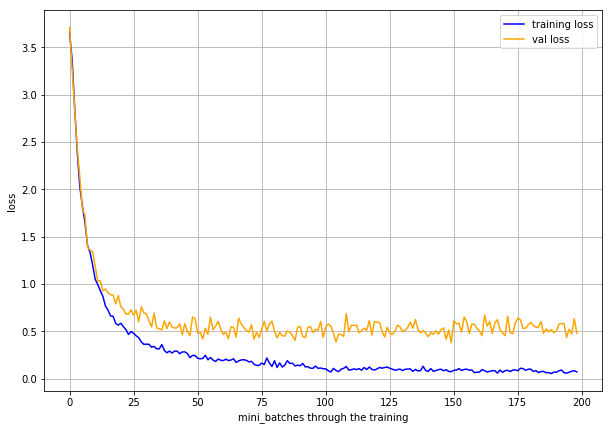

In [15]:
plt.figure(figsize= (10,7))
plt.grid(True)
plt.plot(np.array(new_tr_loss_lis),'b',label='training loss')
plt.plot(np.array(new_val_loss_lis),'orange',label='val loss')
plt.xlabel('mini_batches through the training')
plt.ylabel('loss')
plt.legend()

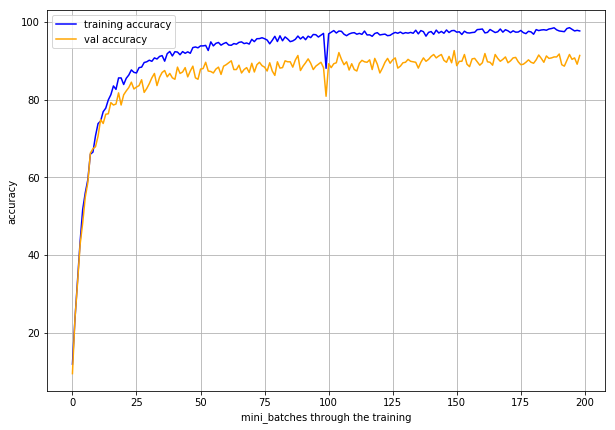

In [16]:
plt.figure(figsize= (10,7))
plt.grid(True)
plt.plot(new_tr_acc_lis,'b',label='training accuracy')
plt.plot(new_val_acc_lis,'orange',label='val accuracy')
plt.xlabel('mini_batches through the training')
plt.ylabel('accuracy')
plt.legend()